In [1]:
from erddapy import ERDDAP
from erddapy.doc_helpers import show_iframe

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cartopy
cartopy.config['data_dir'] = './maps'
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as feat

ImportError: dlopen(/usr/local/lib/python3.9/site-packages/cartopy/_crs.cpython-39-darwin.so, 2): Library not loaded: /usr/local/opt/proj/lib/libproj.19.dylib
  Referenced from: /usr/local/lib/python3.9/site-packages/cartopy/_crs.cpython-39-darwin.so
  Reason: image not found

# List available servers


In [ ]:
from erddapy import servers
{k: [v.url,v.description] for k, v in servers.items()} # dictionary version

# List datasets in server EMODnet

In [3]:
eall = ERDDAP(server="EMODnet")
print(eall.get_search_url(search_for="all",response="html"))
show_iframe(eall.get_search_url(search_for="all",response="html"))
print()
datasetid = eall.get_search_url(search_for="all",response="csv")
df = pd.read_csv(datasetid)
print(
    f'EMODnet has {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)
print(df.columns)
print(df[["Dataset ID","Title"]])

https://erddap.emodnet-physics.eu/erddap/search/advanced.html?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&searchFor=all

EMODnet has 269 tabledap, 57 griddap, and 33 wms endpoints.
Index(['griddap', 'Subset', 'tabledap', 'Make A Graph', 'wms', 'files',
       'Accessible', 'Title', 'Summary', 'FGDC', 'ISO 19115', 'Info',
       'Background Info', 'RSS', 'Email', 'Institution', 'Dataset ID'],
      dtype='object')
                               Dataset ID  \
0                             allDatasets   
1                      BDC_Summary_FV_NRT   
2               EP_ERD_SOO_BIOA_NN_NN_J18   
3                           BDC_Binned_FV   
4                          ZENODO_3250980   
..                                    ...   
322  OBSEA_SPLs_NAXYS_hydrophone_at_OBSEA   
323              TAD_Tsunami_Alert_Device   
32

# Refining search: surface temperature from North Atlantic in 2015



In [4]:
# Constraints
datemin="2015-01-01T00:00:00Z"
datemax="2015-12-31T23:59:59Z"
latmin=15.0
latmax=60.
lonmin=-60.
lonmax=-10.
varstandname="sea_water_temperature"

servconst = {
    "standard_name": varstandname,
    "min_lon": lonmin,
    "max_lon": lonmax,
    "min_lat": latmin,
    "max_lat": latmax,
    "min_time": datemin,
    "max_time": datemax,
    #"cdm_data_type": "trajectoryprofile"
}

## List datasets 


In [5]:
e = ERDDAP(server="EMODnet", protocol='tabledap')
show_iframe(e.get_search_url(response="html", **servconst))

In [6]:
search_url = e.get_search_url(response="csv", **servconst)
search = pd.read_csv(search_url)
print(search.columns)
print(search[["Title","Dataset ID"]].values)


Index(['griddap', 'Subset', 'tabledap', 'Make A Graph', 'wms', 'files',
       'Accessible', 'Title', 'Summary', 'FGDC', 'ISO 19115', 'Info',
       'Background Info', 'RSS', 'Email', 'Institution', 'Dataset ID'],
      dtype='object')
[['A summary of oceanographic data from fishing vessels and gears'
  'BDC_Summary_FV_NRT']
 ['EMODnet Physics - Collection of Sea Temperature (TEMP) Profiles -  MultiPointProfileObservation'
  'EP_ERD_INT_TEMP_AL_PR_NRT']
 ['EMODnet Physics - Collection of Sea Temperature (TEMP) Profiles from Argo/Profilers - MultiPointProfileObservation'
  'EP_ERD_L2A_TEMP_PF_PR_NT_GLO']
 ['EMODnet Physics - Collection of Sea Temperature (TEMP) Profiles from Gliders - MultiPointProfileObservation'
  'EP_ERD_L2A_TEMP_GL_PR_NT_GLO']
 ['EMODnet Physics - Collection of Sea Temperature (TEMP) Profiles from XBT - MultiPointProfileObservation'
  'EP_ERD_L2A_TEMP_XB_PR_NT_GLO']
 ['EMODnet Physics - Collection of Sea Temperature (TEMP) TimeSeries -  MultiPointTimeSeriesObservati

## List variables of dataset

In [7]:
e.dataset_id="EP_ERD_INT_TEMP_AL_PR_NRT"
# List of variables
info_url = e.get_info_url(response='csv')
info = pd.read_csv(info_url)
print(info.head(100))
print()
print(" ".join(info.loc[info["Row Type"] == "variable","Variable Name"]))

     Row Type Variable Name         Attribute Name Data Type  \
0   attribute     NC_GLOBAL          cdm_data_type    String   
1   attribute     NC_GLOBAL  cdm_profile_variables    String   
2   attribute     NC_GLOBAL               citation    String   
3   attribute     NC_GLOBAL                comment    String   
4   attribute     NC_GLOBAL                contact    String   
..        ...           ...                    ...       ...   
95  attribute         depth             _FillValue     float   
96  attribute         depth           actual_range     float   
97  attribute         depth                   axis    String   
98  attribute         depth          ioos_category    String   
99  attribute         depth              long_name    String   

                                                Value  
0                                             Profile  
1                                 time,EP_PLATFORM_ID  
2   Data are the property of the producer/owner di...  
3   Whe

In [8]:
e.constraints= {
    "latitude<=": latmax,
    "latitude>=": latmin,
    "longitude>=": lonmin,
    "longitude<=": lonmax,
    "time>=": datemin,
    "time<=": datemax,
    "TEMP_QC=":1,
    "depth<=":10.,
#    "institution_edmo_code":
}
e.variables= ['time','latitude','longitude','depth', 'TEMP']

#dtype=object
df_emodnet = e.to_pandas()
print(df_emodnet.columns)
print(df_emodnet.shape)

Index(['time (UTC)', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'depth (m)', 'TEMP (degree_Celsius)'],
      dtype='object')
(234299, 5)


## Plot

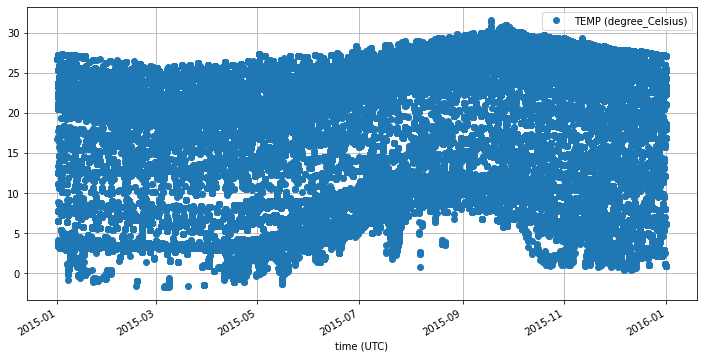

In [9]:
df_emodnet['time (UTC)'] = pd.to_datetime(df_emodnet['time (UTC)'])
plt.figure(figsize=(12,6))
ax = plt.axes()
df_emodnet.plot(x='time (UTC)', y='TEMP (degree_Celsius)',ax=ax, 
                linestyle='None', marker='o',grid='on', legend=True)
plt.show()

# Other ERDDAP servers (IFREMER...)

In [11]:
i = ERDDAP(server='IFREMER',protocol='tabledap')
i.response = 'csv'

search_url = i.get_search_url(response="csv", **servconst)
search = pd.read_csv(search_url)
print(search[["Title","Dataset ID"]].values)
print()

i.dataset_id="ArgoFloats"
# List of variables
info_url = i.get_info_url(response='csv')
info = pd.read_csv(info_url)
print(" ".join(info.loc[info["Row Type"] == "variable","Variable Name"]))
print()

i.constraints= {
    "latitude<=": latmax,
    "latitude>=": latmin,
    "longitude>=": lonmin,
    "longitude<=": lonmax,
    "time>=": datemin,
    "time<=": datemax,
    "temp_adjusted_qc=":"1",
    "pres<=":10.,
#    "platform_number":
}
i.variables= ['time','latitude','longitude','temp_adjusted']

df_argo = i.to_pandas()
print(df_argo.columns)
print(df_argo.shape)

[['Argo Float Measurements' 'ArgoFloats']
 ['Argo float synthetic vertical profiles : BGC data'
  'ArgoFloats-synthetic-BGC']
 ['Global Ocean, In Situ Observation Copernicus (Copernicus Fishing Observing System)'
  'copernicus-fos']
 ['OceanGliders GDAC trajectories' 'OceanGlidersGDACTrajectories']]

fileNumber data_type format_version handbook_version reference_date_time date_creation date_update platform_number project_name pi_name cycle_number direction data_center dc_reference data_state_indicator data_mode platform_type float_serial_no firmware_version wmo_inst_type time time_qc time_location latitude longitude position_qc positioning_system profile_pres_qc profile_temp_qc profile_psal_qc vertical_sampling_scheme config_mission_number pres pres_qc pres_adjusted pres_adjusted_qc pres_adjusted_error temp temp_qc temp_adjusted temp_adjusted_qc temp_adjusted_error psal psal_qc psal_adjusted psal_adjusted_qc psal_adjusted_error doxy doxy_qc temp_doxy temp_doxy_qc molar_doxy molar_doxy_

In [12]:
i.dataset_id="OceanGlidersGDACTrajectories"
# List of variables
info_url = i.get_info_url(response='csv')
info = pd.read_csv(info_url)
print(" ".join(info.loc[info["Row Type"] == "variable","Variable Name"]))
print()

i.constraints= {
    "latitude<=": latmax,
    "latitude>=": latmin,
    "longitude>=": lonmin,
    "longitude<=": lonmax,
    "time>=": datemin,
    "time<=": datemax,
    "TEMP_QC=":1,
    "PRES<=":10.,
#    "platform_number":
}
i.variables= ['time','latitude','longitude','TEMP']

df_glider = i.to_pandas()
print(df_glider.columns)
print(df_glider.shape)

platform_deployment time JULD latitude longitude TIME_QC JULD_QC POSITION_QC PSAL TEMP CNDC PRES PSAL_QC TEMP_QC CNDC_QC PRES_QC PSAL_UNCERTAINTY TEMP_UNCERTAINTY CNDC_UNCERTAINTY PRES_UNCERTAINTY MOLAR_DOXY TEMP_DOXY BPHASE_DOXY DPHASE_DOXY RPHASE_DOXY MOLAR_DOXY_QC TEMP_DOXY_QC BPHASE_DOXY_QC DPHASE_DOXY_QC RPHASE_DOXY_QC MOLAR_DOXY_UNCERTAINTY TEMP_DOXY_UNCERTAINTY BPHASE_DOXY_UNCERTAINTY DPHASE_DOXY_UNCERTAINTY RPHASE_DOXY_UNCERTAINTY CHLA CDOM BBP700 CHLA_QC CDOM_QC BBP700_QC CHLA_UNCERTAINTY CDOM_UNCERTAINTY BBP700_UNCERTAINTY PHASE_NUMBER POSITIONING_METHOD

Index(['time (UTC)', 'latitude (degrees_north)', 'longitude (degrees_east)',
       'TEMP (degree_Celsius)'],
      dtype='object')
(1193, 4)


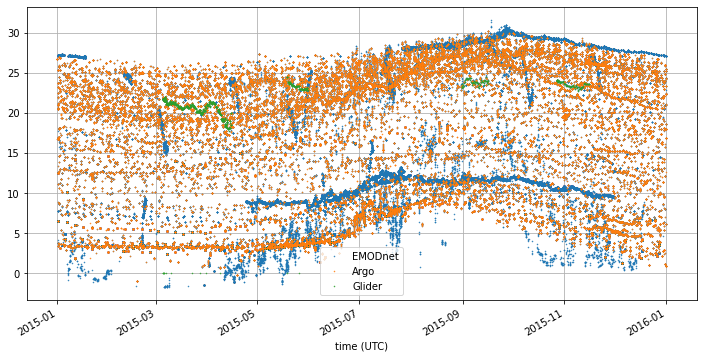

In [13]:
df_argo['time (UTC)'] = pd.to_datetime(df_argo['time (UTC)'])
df_glider['time (UTC)'] = pd.to_datetime(df_glider['time (UTC)'])


plt.figure(figsize=(12,6))
ax = plt.axes()
df_emodnet.plot(x='time (UTC)', y='TEMP (degree_Celsius)',ax=ax, 
                linestyle='None', marker='o',grid='on', markersize=0.5, label="EMODnet", legend=True)
df_argo.plot(x='time (UTC)', y='temp_adjusted (degree_Celsius)',ax=ax, 
                linestyle='None', marker='o',grid='on', markersize=0.5, label="Argo")
df_glider.plot(x='time (UTC)', y='TEMP (degree_Celsius)',ax=ax, 
                linestyle='None', marker='o',grid='on', markersize=0.5, label="Glider")
plt.show()


# Scatter plot in map

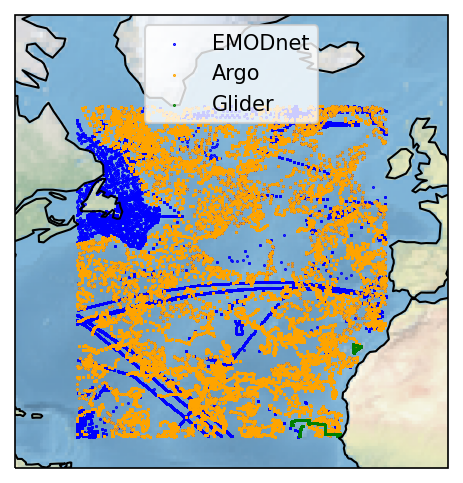

In [15]:
proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=150)
ax = plt.axes(projection=proj)
ax.set_extent([lonmin-10, lonmax+10, latmax+5, latmin-5])
ax.stock_img()
ax.coastlines()
sc=ax.scatter(df_emodnet['longitude (degrees_east)'],df_emodnet['latitude (degrees_north)'],
              c='blue',s=0.2, label= "EMODnet",
             transform=ccrs.PlateCarree())
sc=ax.scatter(df_argo['longitude (degrees_east)'],df_argo['latitude (degrees_north)'],
              c='orange',s=0.2, label="Argo",
             transform=ccrs.PlateCarree())
sc=ax.scatter(df_glider['longitude (degrees_east)'],df_glider['latitude (degrees_north)'],
              c='green',s=0.2, label="Glider",
             transform=ccrs.PlateCarree())
ax.legend()
plt.show()

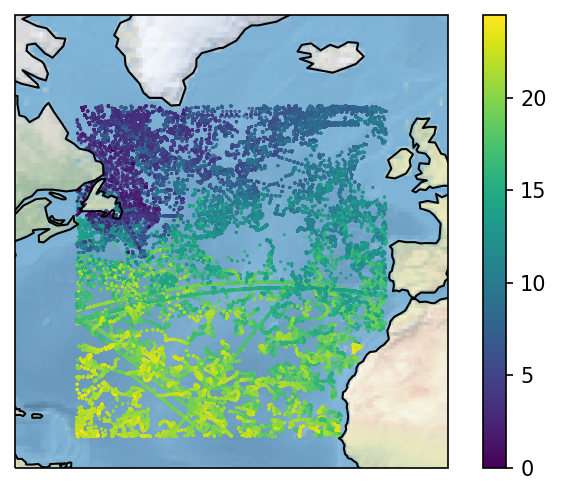

In [16]:
proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=150)
ax = plt.axes(projection=proj)
ax.set_extent([lonmin-10, lonmax+10, latmax+5, latmin-5])
ax.stock_img()
ax.coastlines()
sc=ax.scatter(df_emodnet['longitude (degrees_east)'],df_emodnet['latitude (degrees_north)'],
              c=df_emodnet['TEMP (degree_Celsius)'],s=0.2,
             transform=ccrs.PlateCarree())
sc=ax.scatter(df_argo['longitude (degrees_east)'],df_argo['latitude (degrees_north)'],
              c=df_argo['temp_adjusted (degree_Celsius)'],s=0.2,
             transform=ccrs.PlateCarree())
sc=ax.scatter(df_glider['longitude (degrees_east)'],df_glider['latitude (degrees_north)'],
              c=df_glider['TEMP (degree_Celsius)'],s=0.2,
             transform=ccrs.PlateCarree())

plt.colorbar(sc)
plt.show()

## Bonus track. Griddap data background (temperature climatology)

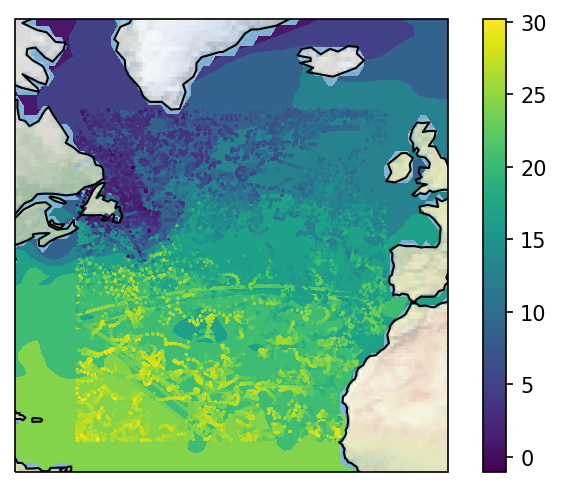

In [17]:
g = ERDDAP(
  server='https://jeodpp.jrc.ec.europa.eu/services/erddap',
  protocol='griddap',
)
g.response = 'csv'
g.dataset_id = 'GLODAPv2_2016b_CMEMS'
g.variables = ['temperature']
df_glodapgrid = g.to_pandas()

surftemp=df_glodapgrid.loc[df_glodapgrid['depth_surface (count)'] == 1,:]
lat=surftemp['latitude (degrees_north)'].unique()
lon=surftemp['longitude (degrees_east)'].unique()
temp=(surftemp['temperature (degrees celcius)']).values.reshape(180,360)

proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=150)
ax = plt.axes(projection=proj)
ax.set_extent([lonmin-10, lonmax+10, latmax+5, latmin-5])
ax.stock_img()
ax.coastlines()
sc=ax.contourf(lon,lat,temp,transform=ccrs.PlateCarree())
sc=ax.scatter(df_emodnet['longitude (degrees_east)'],df_emodnet['latitude (degrees_north)'],
              c=df_emodnet['TEMP (degree_Celsius)'],s=0.2,
             transform=ccrs.PlateCarree())
sc=ax.scatter(df_argo['longitude (degrees_east)'],df_argo['latitude (degrees_north)'],
              c=df_argo['temp_adjusted (degree_Celsius)'],s=0.2,
             transform=ccrs.PlateCarree())
plt.colorbar(sc)